In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import scipy.sparse
from datasets import load_dataset, Dataset
import gensim
from collections import Counter
from textblob import TextBlob
from datetime import datetime


# Importing Data

In [2]:
sentiment_import = load_dataset("bartoszmaj/vader_sentiment_full")
topic_import = load_dataset("bartoszmaj/topics_labelled")
stance_import = load_dataset("bartoszmaj/stance_predictions")

Found cached dataset parquet (/home/ec22283/.cache/huggingface/datasets/bartoszmaj___parquet/bartoszmaj--vader_sentiment_full-90f06cb4a1e85dd0/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ec22283/.cache/huggingface/datasets/bartoszmaj___parquet/bartoszmaj--topics_labelled-119546883b7ae67f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/home/ec22283/.cache/huggingface/datasets/bartoszmaj___parquet/bartoszmaj--stance_predictions-c8c892db9c9c0dc9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
comment_df = pd.read_csv("comments.csv")

In [4]:
comment_df.head(1)

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,imlddn9,2qh3l,news,False,1661990368,https://old.reddit.com/r/news/comments/x2cszk/...,Yeah but what the above commenter is saying is...,0.5719,2


In [5]:
sentiment_list, topic_list, stance_list = sentiment_import["train"]["sentiment_cat"], topic_import["train"]["topics"], stance_import["train"]["predictions"]

In [6]:
len(sentiment_list), len(topic_list), len(stance_list)

(4600698, 4600698, 4600698)

In [7]:
main_df = comment_df[["subreddit.name", "score"]]
main_df = main_df.rename(columns = {"subreddit.name" : "sub"})

In [8]:
main_df["stance"] = stance_list
main_df["topic"] = topic_list
main_df["sentiment"] = sentiment_list

In [9]:
comments_time = comment_df["created_utc"].to_list()
year = []
for utc in comments_time:
    dt = datetime.fromtimestamp(utc)
    year.append(dt.year)
main_df["year"] = year

In [10]:
main_df = main_df[main_df["year"] != 2009]

In [11]:
topics = {0:"science",
          1:"energy",
          2:"family", 
          3:"politics",
          4:"humanity", 
          5:"climate",
          6:"information",}

In [12]:
main_df["topic"] = main_df["topic"].replace(topics)

In [13]:
main_df.head()

,sub,score,stance,topic,sentiment,year
0,news,2,Pro,family,positive,2022
1,ohio,2,Pro,energy,negative,2022
2,newzealand,1,Pro,climate,negative,2022
3,sacramento,4,Pro,climate,neutral,2022
4,askreddit,1,Neutral,science,positive,2022


In [14]:
(main_df["stance"].value_counts())/len(main_df) * 100

stance
Pro        60.091660
Neutral    32.250388
Anti        7.657952
Name: count, dtype: float64

In [15]:
(main_df["topic"].value_counts())/len(main_df) * 100

topic
family         23.993657
science        23.854961
energy         20.637860
climate         8.905546
humanity        8.466112
politics        8.081670
information     6.060193
Name: count, dtype: float64

In [16]:
(main_df["sentiment"].value_counts())/len(main_df) * 100

sentiment
negative    46.325197
positive    44.594697
neutral      9.080106
Name: count, dtype: float64

# Sentiment Data

In [17]:
(main_df["sentiment"].value_counts()/len(main_df)) * 100

sentiment
negative    46.325197
positive    44.594697
neutral      9.080106
Name: count, dtype: float64

In [18]:
common_subreddits = [key for key, value in main_df["sub"].value_counts().head(15).to_dict().items()]

In [19]:
sub_sent = main_df[main_df["sub"].isin(common_subreddits)].groupby(["sub"])["sentiment"].value_counts().unstack(1)
sub_sent_norm = round(sub_sent.div(sub_sent.sum(axis = 1), axis = 0)*100, 2)
sub_sent_norm = sub_sent_norm.reset_index(level = 0)
sub_sent_norm["sub"] = sub_sent_norm["sub"].astype("category")
sub_sent_norm["sub"] = sub_sent_norm["sub"].cat.set_categories(common_subreddits)
sub_sent_norm.sort_values(["sub"]).set_index("sub", drop = True)

sentiment,negative,neutral,positive
sub,,,
politics,47.69,7.66,44.64
worldnews,49.96,8.42,41.63
askreddit,45.88,18.10,36.02
collapse,54.44,7.05,38.51
news,51.38,9.33,39.29
futurology,46.35,7.59,46.06
science,42.72,9.11,48.17
environment,47.24,8.32,44.44
canada,45.05,7.94,47.01


<Axes: title={'center': 'Shifts In Sentiment Between 2010 and 2022'}, xlabel='Year', ylabel='Percentage'>

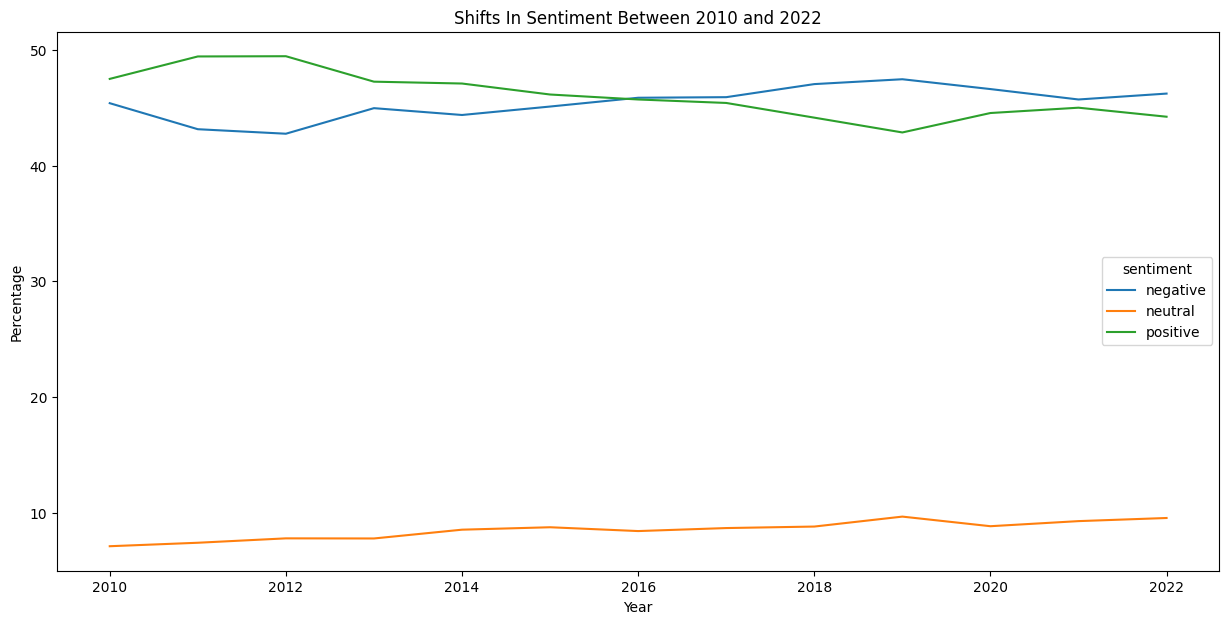

In [20]:
year_sent = pd.DataFrame(main_df.groupby(["year"])["sentiment"].value_counts()).unstack(1)
year_sent_norm = round(year_sent.div(year_sent.sum(axis=1), axis=0)*100, 2)["count"]
year_sent_norm.reset_index(level = 0).set_index("year",drop = True).plot(figsize = (15,7), 
                                                                         title = "Shifts In Sentiment Between 2010 and 2022",
                                                                         xlabel = "Year",
                                                                         ylabel = "Percentage")

In [21]:
series = main_df.groupby(["sentiment"])["score"].mean().sort_values(ascending = False)
pd.DataFrame(series)

,score
sentiment,
negative,10.011322
positive,9.193712
neutral,8.969242


# Topic Data

In [22]:
(main_df["topic"].value_counts()/len(main_df)) * 100

topic
family         23.993657
science        23.854961
energy         20.637860
climate         8.905546
humanity        8.466112
politics        8.081670
information     6.060193
Name: count, dtype: float64

In [23]:
common_subreddits = [key for key, value in main_df["sub"].value_counts().head(100).to_dict().items()]

In [24]:
sub_sent = main_df[main_df["sub"].isin(common_subreddits)].groupby(["sub"])["topic"].value_counts().unstack(1)
sub_sent_norm = round(sub_sent.div(sub_sent.sum(axis = 1), axis = 0)*100, 2)
sub_sent_norm = sub_sent_norm.reset_index(level = 0)
sub_sent_norm["sub"] = sub_sent_norm["sub"].astype("category")
sub_sent_norm["sub"] = sub_sent_norm["sub"].cat.set_categories(common_subreddits)
topic_df = sub_sent_norm.sort_values(["sub"]).set_index("sub", drop = True)
topic_df

topic,climate,energy,family,humanity,information,politics,science
sub,,,,,,,
politics,6.16,20.06,26.70,16.31,3.40,9.08,18.28
worldnews,11.54,21.34,24.64,8.13,6.09,8.13,20.13
askreddit,14.72,14.89,23.30,6.43,6.92,5.75,28.00
collapse,14.17,18.56,21.30,6.78,5.88,11.07,22.24
news,8.70,19.58,25.98,8.55,7.77,7.74,21.68
...,...,...,...,...,...,...,...
wallstreetbets,9.19,29.44,14.41,8.00,6.06,4.24,28.65
television,4.55,19.27,33.41,7.78,2.84,7.19,24.96
documentaries,7.55,22.51,29.17,6.40,4.30,9.20,20.88


In [25]:
topic_df.idxmax(axis=1).value_counts()

family         53
science        24
energy         21
information     1
humanity        1
Name: count, dtype: int64

In [26]:
highest = pd.DataFrame(topic_df.idxmax(axis=1),
                       columns = ["max_topic"])

In [27]:
highest[highest["max_topic"] == "science"]

,max_topic
sub,
askreddit,science
collapse,science
unitedkingdom,science
memes,science
newzealand,science
whitepeopletwitter,science
interestingasfuck,science
publicfreakout,science
teenagers,science


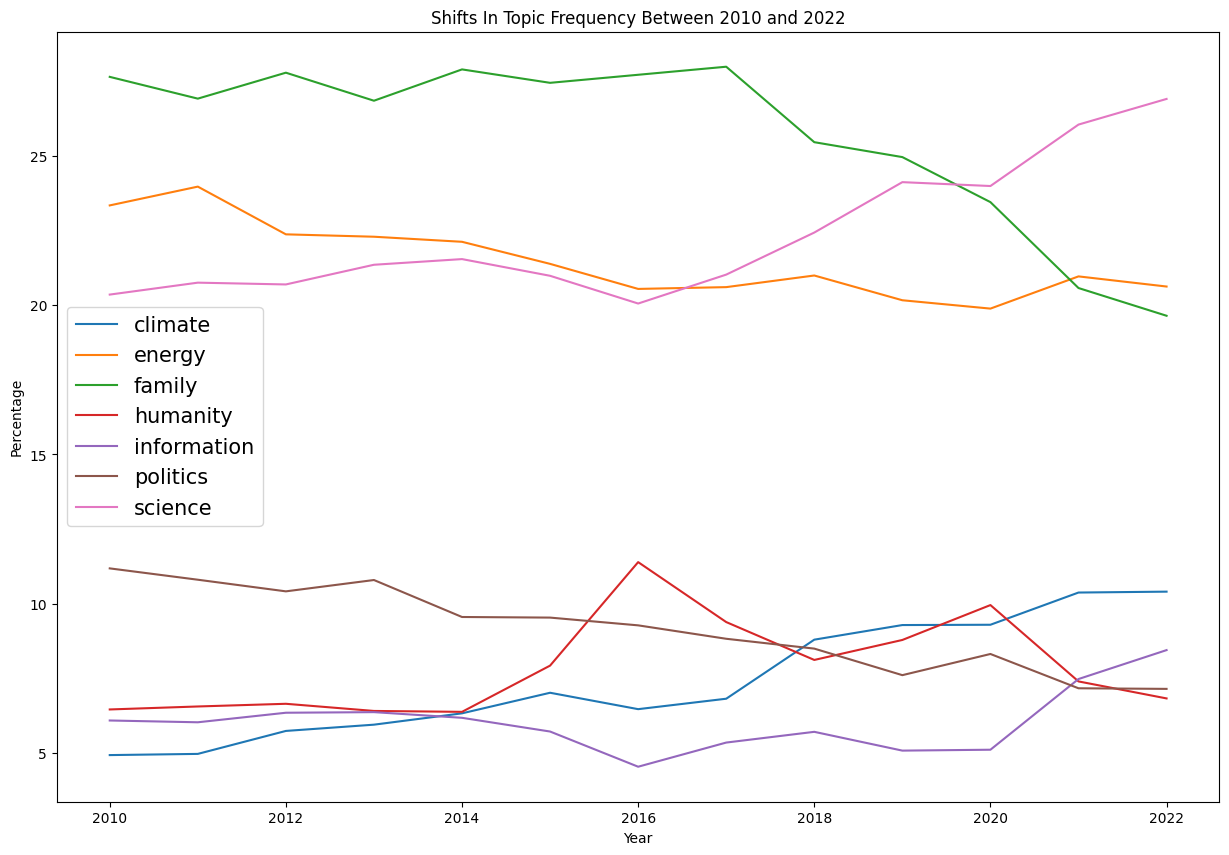

In [28]:
year_sent = pd.DataFrame(main_df.groupby(["year"])["topic"].value_counts()).unstack(1)
year_sent_norm = round(year_sent.div(year_sent.sum(axis=1), axis=0)*100, 2)["count"]
year_sent_norm.reset_index(level = 0).set_index("year",drop = True).plot(figsize = (15, 10), 
                                                                         title = "Shifts In Topic Frequency Between 2010 and 2022", 
                                                                         xlabel = "Year", 
                                                                         ylabel = "Percentage")
plt.legend(fontsize = 15)

In [29]:
series = main_df.groupby(["topic"])["score"].mean().sort_values(ascending = False)
pd.DataFrame(series)

,score
topic,
humanity,12.131379
science,10.154916
politics,10.079545
climate,9.146989
family,9.106578
energy,8.789929
information,7.827188


# Stance Data

In [30]:
common_subreddits = [key for key, value in main_df["sub"].value_counts().head(100).to_dict().items()]

In [31]:
sub_sent = main_df[main_df["sub"].isin(common_subreddits)].groupby(["sub"])["stance"].value_counts().unstack(1)
sub_sent_norm = round(sub_sent.div(sub_sent.sum(axis = 1), axis = 0)*100, 2)
sub_sent_norm = sub_sent_norm.reset_index(level = 0)
sub_sent_norm["sub"] = sub_sent_norm["sub"].astype("category")
sub_sent_norm["sub"] = sub_sent_norm["sub"].cat.set_categories(common_subreddits)
stance_df = sub_sent_norm.sort_values(["sub"]).set_index("sub", drop = True)

In [32]:
top_100 = stance_df["Anti"].sort_values(ascending = False)
(top_100[(top_100 > 6.5) & (top_100 < 9.5)]).count()

41

In [33]:
(top_100[(top_100 > 9.5)]).count(), (top_100[(top_100 > 9.5)])

(26,
 sub
 the_donald               26.85
 conspiracy               21.69
 climateskeptics          20.48
 conservative             19.86
 anarcho_capitalism       17.75
 worldpolitics            13.94
 libertarian              13.10
 insanepeoplefacebook     12.75
 documentaries            12.29
 selfawarewolves          11.94
 adviceanimals            11.24
 skeptic                  11.12
 joerogan                 11.11
 atheism                  11.09
 jordanpeterson           10.99
 funny                    10.93
 politicalhumor           10.74
 christianity             10.28
 wtf                      10.23
 politicalcompassmemes    10.16
 nottheonion               9.98
 australianpolitics        9.95
 pics                      9.81
 facepalm                  9.80
 damnthatsinteresting      9.57
 murderedbywords           9.56
 Name: Anti, dtype: float64)

In [34]:
(top_100[(top_100 < 6.5)]).count(), (top_100[(top_100 < 6.5)])

(32,
 sub
 truereddit             6.29
 nostupidquestions      6.19
 economics              6.15
 antiwork               5.95
 explainlikeimfive      5.94
 iama                   5.93
 neoliberal             5.87
 europe                 5.83
 onguardforthee         5.71
 coronavirus            5.64
 politicaldiscussion    5.54
 ireland                5.49
 space                  5.48
 mapporn                5.41
 collapse               5.26
 unitedkingdom          5.22
 askanamerican          5.20
 ukpolitics             5.16
 vancouver              5.05
 moderatepolitics       4.80
 askaliberal            4.66
 climate                4.61
 newzealand             4.36
 changemyview           4.31
 canadapolitics         4.19
 sandersforpresident    3.72
 energy                 3.72
 askscience             3.51
 india                  3.10
 childfree              2.48
 vegan                  1.99
 yangforpresidenthq     1.72
 Name: Anti, dtype: float64)

<Axes: title={'center': 'Shifts In Stance Between 2010 and 2022'}, xlabel='Year', ylabel='Percentage'>

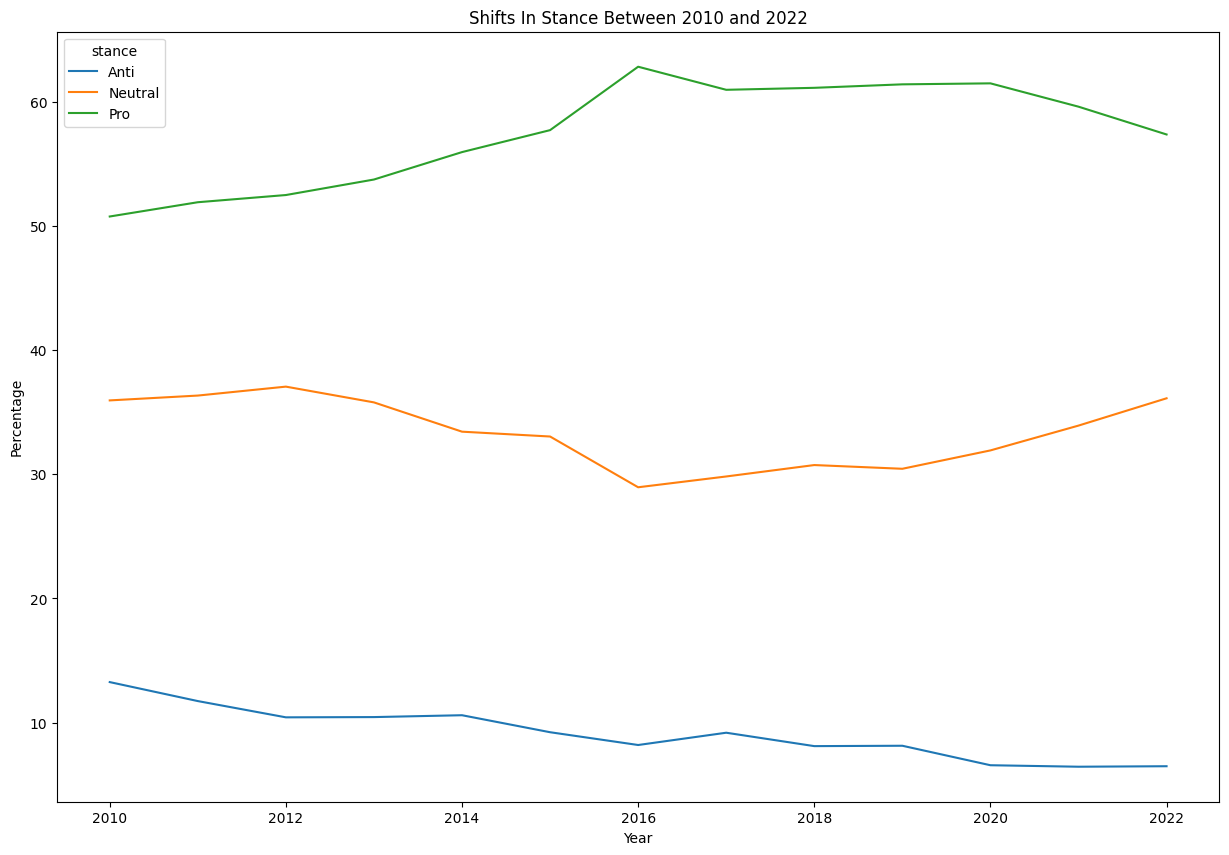

In [35]:
year_sent = pd.DataFrame(main_df.groupby(["year"])["stance"].value_counts()).unstack(1)
year_sent_norm = round(year_sent.div(year_sent.sum(axis=1), axis=0)*100, 2)["count"]
year_sent_norm.reset_index(level = 0).set_index("year",drop = True).plot(figsize = (15, 10), 
                                                                         title = "Shifts In Stance Between 2010 and 2022", 
                                                                         xlabel = "Year", 
                                                                         ylabel = "Percentage")

In [36]:
series = main_df.groupby(["stance"])["score"].mean().sort_values(ascending = False)
pd.DataFrame(series)

,score
stance,
Pro,9.934229
Neutral,9.438009
Anti,7.033890


# Stance Per Topic

In [37]:
sub_sent = main_df.groupby(["topic"])["stance"].value_counts().unstack(1)
sub_sent_norm = round(sub_sent.div(sub_sent.sum(axis = 1), axis = 0)*100, 2)
sub_sent_norm

stance,Anti,Neutral,Pro
topic,,,
climate,4.85,19.68,75.48
energy,6.55,29.57,63.88
family,11.09,27.75,61.16
humanity,6.34,29.86,63.80
information,11.68,35.45,52.87
politics,7.10,38.45,54.45
science,5.85,41.72,52.43


# Sentiment Per Stance

In [38]:
sub_sent = main_df.groupby(["stance"])["sentiment"].value_counts().unstack(1)
sub_sent_norm = round(sub_sent.div(sub_sent.sum(axis = 1), axis = 0)*100, 2)
sub_sent_norm

sentiment,negative,neutral,positive
stance,,,
Anti,56.12,8.76,35.12
Neutral,37.29,13.99,48.72
Pro,49.93,6.49,43.59


# Sentiment Per Topic

In [39]:
sub_sent = main_df.groupby(["topic"])["sentiment"].value_counts().unstack(1)
sub_sent_norm = round(sub_sent.div(sub_sent.sum(axis = 1), axis = 0)*100, 2)
sub_sent_norm

sentiment,negative,neutral,positive
topic,,,
climate,55.07,10.53,34.40
energy,45.56,4.93,49.51
family,49.93,8.25,41.82
humanity,44.86,9.52,45.62
information,38.61,18.49,42.90
politics,44.92,9.33,45.75
science,43.06,10.33,46.61


# Score Per Sentiment 

In [40]:
print(main_df[main_df["sentiment"] == "positive"]["score"].mean())
print(main_df[main_df["sentiment"] == "neutral"]["score"].mean())
print(main_df[main_df["sentiment"] == "negative"]["score"].mean())

9.193712329394746
8.96924222258395
10.011321829453742
